# Exploratory Data Analysis on Extracted TypeNet Features


In [47]:
!which python
!python --version

/Users/loripickering/Projects/eda/venv-3.12.5/bin/python
Python 3.12.10


In [48]:
import os
# import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [67]:
# Where do I save the summary_session.csv file?
# You should probably save this with the processed data to keep track of which data it was run on
save_summary_session_directory = "processed_data-2025-05-24_144726-Loris-MBP.cable.rcn.com"

data_path = "processed_data-2025-05-24_144726-Loris-MBP.cable.rcn.com/typenet_features.csv"
df = pd.read_csv(data_path)


In [50]:
# Convert timing features to milliseconds
timing_features = ['HL', 'IL', 'PL', 'RL']
for feature in timing_features:
    df[f'{feature}_ms'] = df[feature] / 1_000_000

print(f"Loaded {len(df):,} keystroke pairs from {df['user_id'].nunique()} users")
print(f"Validity rate: {(df['valid'].sum() / len(df) * 100):.2f}%")

Loaded 273,548 keystroke pairs from 36 users
Validity rate: 94.98%


## 1. Data Overview and Quality Assessment


Dataset shape: (273548, 22)

Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273548 entries, 0 to 273547
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   user_id            273548 non-null  int64  
 1   platform_id        273548 non-null  int64  
 2   video_id           273548 non-null  int64  
 3   session_id         273548 non-null  int64  
 4   sequence_id        273548 non-null  int64  
 5   key1               273548 non-null  object 
 6   key2               273548 non-null  object 
 7   key1_press         270816 non-null  float64
 8   key1_release       266088 non-null  float64
 9   key2_press         270986 non-null  float64
 10  key2_release       265737 non-null  float64
 11  HL                 263356 non-null  float64
 12  IL                 259823 non-null  float64
 13  PL                 259823 non-null  float64
 14  RL                 259823 non-null  float64
 15  ke

,Total Records,Valid Records,Invalid Records,Validity Rate (%)
0,273548,259823,13725,94.982599


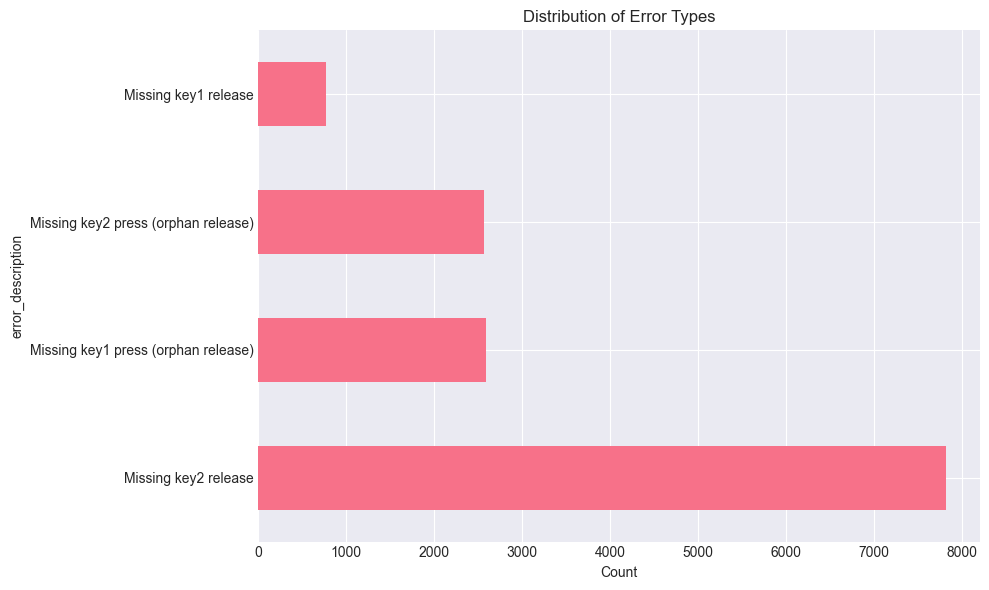

In [51]:
# Data shape and basic info
print("Dataset shape:", df.shape)
print("\nColumn information:")
df.info()

# %%
# Validity analysis
validity_summary = pd.DataFrame({
    'Total Records': [len(df)],
    'Valid Records': [df['valid'].sum()],
    'Invalid Records': [(~df['valid']).sum()],
    'Validity Rate (%)': [(df['valid'].sum() / len(df) * 100)]
})
display(validity_summary)

# Error distribution
error_dist = df[~df['valid']]['error_description'].value_counts()
plt.figure(figsize=(10, 6))
error_dist.plot(kind='barh')
plt.title('Distribution of Error Types')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

## 2. Timing Features Analysis


In [52]:
# Filter valid data for timing analysis
valid_df = df[df['valid']].copy()

# Timing features summary statistics
timing_stats = valid_df[[f'{f}_ms' for f in timing_features]].describe()
display(timing_stats.round(2))

,HL_ms,IL_ms,PL_ms,RL_ms
count,259823.00,259823.00,259823.00,259823.00
mean,100.95,327.69,428.63,430.32
std,110.14,3146.86,3146.29,3159.37
min,0.12,-29688.77,0.39,-29687.66
25%,71.15,27.64,127.67,127.26
50%,90.16,95.45,184.24,188.14
75%,115.70,200.50,294.07,299.95
max,29714.85,849340.69,849464.61,849443.67


# Timing features distributions


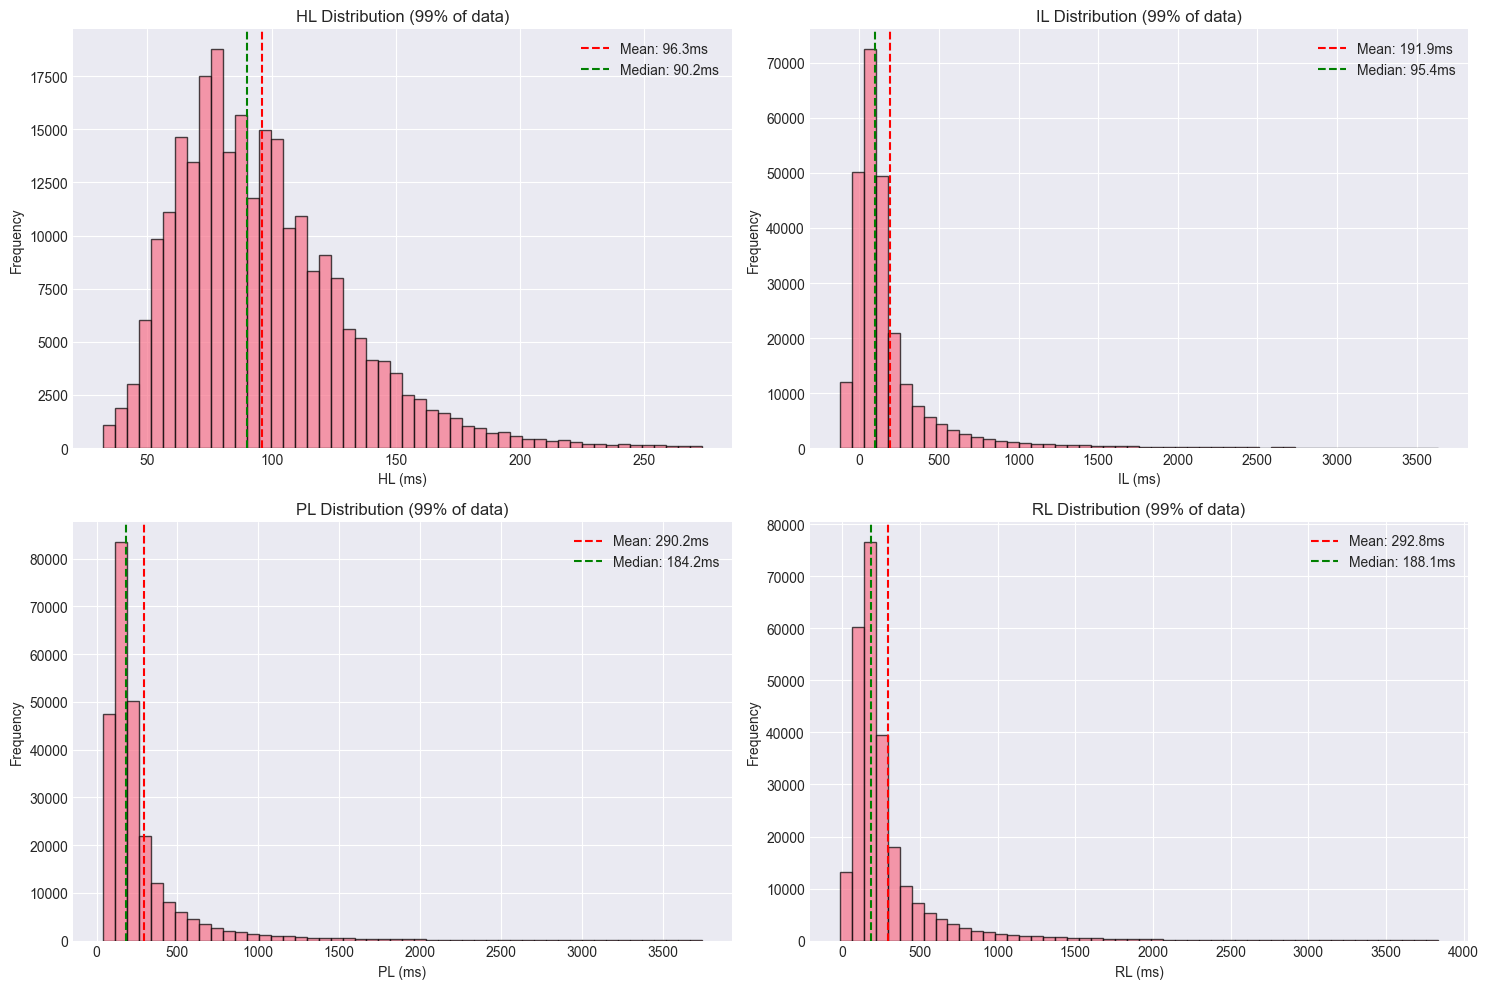

In [53]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(timing_features):
    feature_ms = f'{feature}_ms'
    
    # Remove extreme outliers for better visualization (keep 99% of data)
    q99 = valid_df[feature_ms].quantile(0.99)
    q01 = valid_df[feature_ms].quantile(0.01)
    filtered = valid_df[(valid_df[feature_ms] >= q01) & (valid_df[feature_ms] <= q99)]
    
    axes[i].hist(filtered[feature_ms], bins=50, alpha=0.7, edgecolor='black')
    axes[i].axvline(filtered[feature_ms].mean(), color='red', linestyle='--', label=f'Mean: {filtered[feature_ms].mean():.1f}ms')
    axes[i].axvline(filtered[feature_ms].median(), color='green', linestyle='--', label=f'Median: {filtered[feature_ms].median():.1f}ms')
    axes[i].set_xlabel(f'{feature} (ms)')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'{feature} Distribution (99% of data)')
    axes[i].legend()

plt.tight_layout()
plt.show()

## 3. User-Level Analysis


In [54]:
# Calculate user-level statistics
user_stats = valid_df.groupby('user_id').agg({
    'key1': 'count',
    'HL_ms': ['mean', 'std', 'median'],
    'IL_ms': ['mean', 'std', 'median'],
    'PL_ms': ['mean', 'std', 'median'],
    'RL_ms': ['mean', 'std', 'median']
}).round(2)

user_stats.columns = ['_'.join(col) for col in user_stats.columns]
user_stats = user_stats.rename(columns={'key1_count': 'total_keystrokes'})

# Add error rate
error_rates = df.groupby('user_id')['valid'].agg(['sum', 'count'])
error_rates['error_rate'] = 1 - (error_rates['sum'] / error_rates['count'])
user_stats['error_rate'] = error_rates['error_rate']

display(user_stats.head(10))

,total_keystrokes,HL_ms_mean,HL_ms_std,HL_ms_median,IL_ms_mean,IL_ms_std,IL_ms_median,PL_ms_mean,PL_ms_std,PL_ms_median,RL_ms_mean,RL_ms_std,RL_ms_median,error_rate
user_id,,,,,,,,,,,,,,
1001,9013,89.91,45.62,80.48,126.79,1171.46,32.13,216.70,1176.85,119.97,217.17,1175.39,127.92,0.032109
1002,5166,96.19,63.68,87.99,143.88,1343.34,48.04,240.08,1346.25,135.92,240.18,1347.75,136.40,0.022332
1003,4135,97.38,44.44,92.22,401.98,2346.98,77.45,499.35,2348.18,165.30,500.29,2361.58,171.48,0.080089
1004,4572,81.27,34.43,79.74,152.54,1411.77,48.52,233.81,1420.44,127.44,234.46,1414.16,135.17,0.023494
1005,6984,106.74,99.13,95.85,126.89,954.23,41.21,233.62,956.31,137.22,235.17,969.69,143.94,0.064810
1006,9353,124.09,93.88,113.42,356.48,3452.23,34.52,480.56,3457.77,144.00,492.93,3590.88,153.56,0.084834
1007,4814,99.57,109.96,83.91,468.36,2169.09,130.80,567.93,2172.47,219.77,569.21,2207.36,215.38,0.038738
1008,4413,104.40,85.43,88.28,178.71,1024.23,53.61,283.11,1026.25,143.60,282.60,1049.93,151.78,0.037304
1009,3625,113.99,93.31,103.89,521.48,2926.52,112.16,635.47,2932.09,217.08,637.64,2957.93,216.06,0.060394


# User clustering based on timing patterns


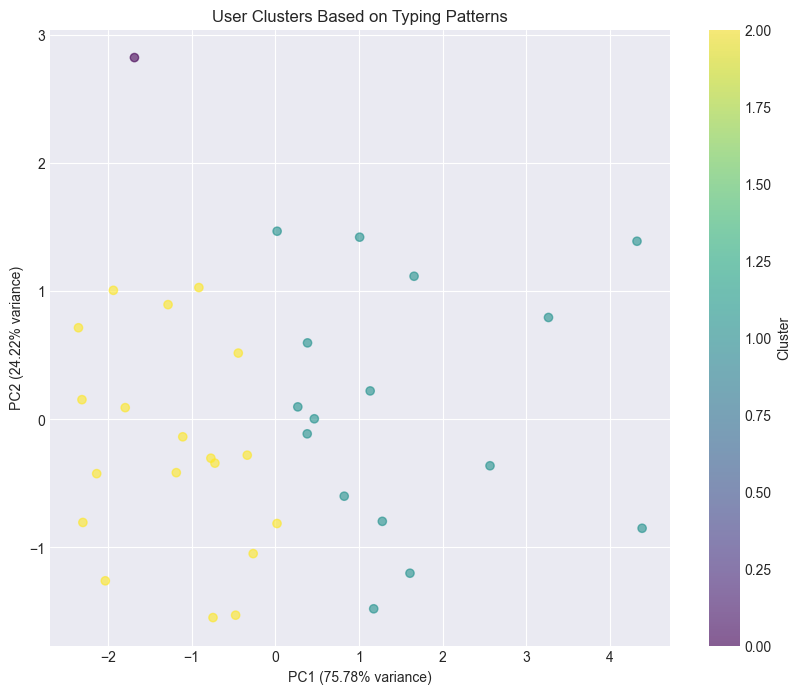

In [55]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Prepare features for clustering
cluster_features = ['HL_ms_mean', 'IL_ms_mean', 'PL_ms_mean', 'RL_ms_mean']
X = user_stats[cluster_features].dropna()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform clustering
kmeans = KMeans(n_clusters=3, random_state=42)
user_stats.loc[X.index, 'cluster'] = kmeans.fit_predict(X_scaled)

# Visualize clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.6)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('User Clusters Based on Typing Patterns')
plt.colorbar(scatter, label='Cluster')
plt.show()

## 4. Platform, Video, and Session Variations


In [56]:
# Platform comparison
platform_comparison = valid_df.groupby('platform_id')[['HL_ms', 'IL_ms', 'PL_ms', 'RL_ms']].agg(['mean', 'std', 'count'])
display(platform_comparison.round(2))

HL_ms                   IL_ms                    PL_ms           \
               mean     std   count    mean      std   count    mean      std   
platform_id                                                                     
1            100.03   88.41  106668  357.29  3760.87  106668  457.32  3761.41   
2            101.52   93.61   85254  309.73  2751.24   85254  411.25  2751.01   
3            101.67  152.10   67901  303.72  2483.44   67901  405.39  2479.68   

                      RL_ms                   
              count    mean      std   count  
platform_id                                   
1            106668  458.64  3766.14  106668  
2             85254  412.80  2760.67   85254  
3             67901  407.83  2518.31   67901

# Visualize platform differences


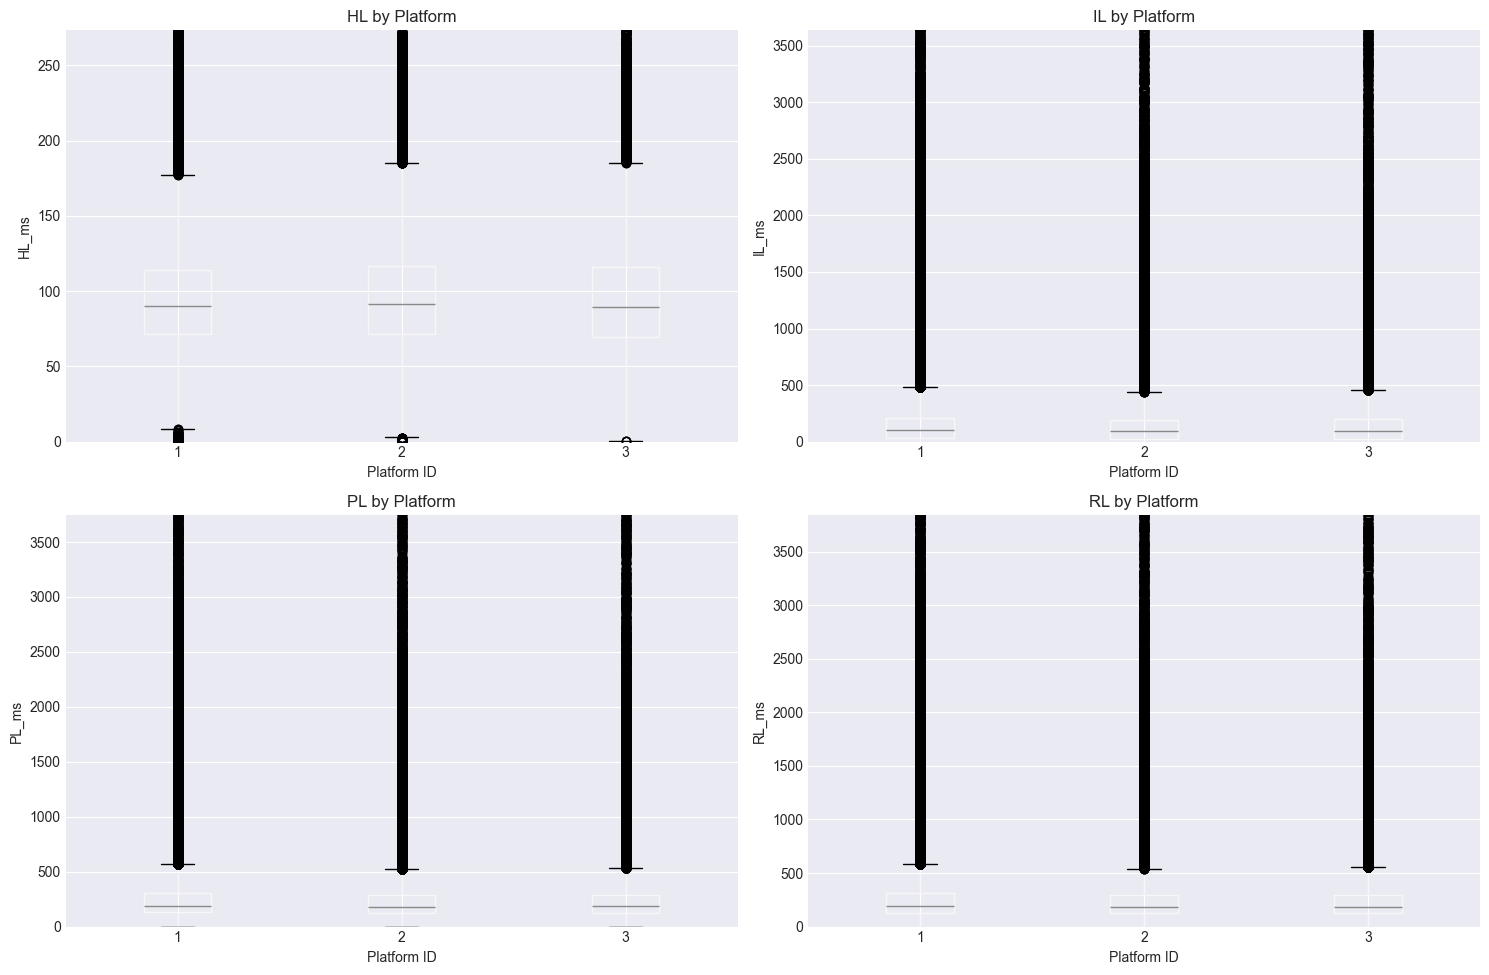

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(['HL_ms', 'IL_ms', 'PL_ms', 'RL_ms']):
    valid_df.boxplot(column=feature, by='platform_id', ax=axes[i])
    axes[i].set_title(f'{feature.replace("_ms", "")} by Platform')
    axes[i].set_xlabel('Platform ID')
    axes[i].set_ylabel(f'{feature}')
    
    # Remove outliers for better visualization
    q99 = valid_df[feature].quantile(0.99)
    axes[i].set_ylim(0, q99)

plt.suptitle('')
plt.tight_layout()
plt.show()

# Video analysis - typing speed progression


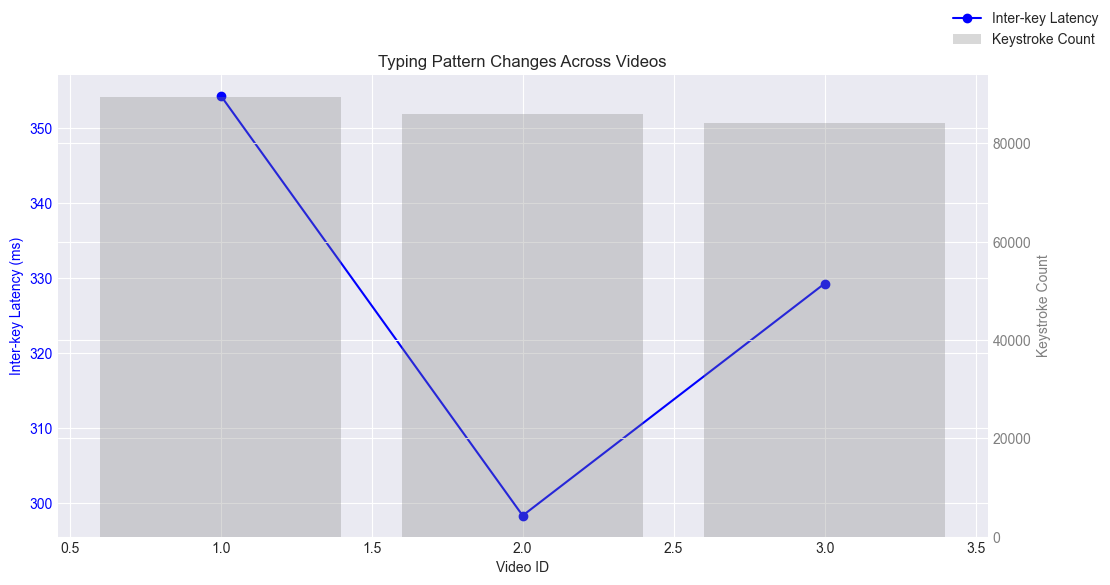

In [58]:
video_progression = valid_df.groupby('video_id').agg({
    'IL_ms': 'mean',
    'HL_ms': 'mean',
    'key1': 'count'
}).rename(columns={'key1': 'keystroke_count'})

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(video_progression.index, video_progression['IL_ms'], 'b-', marker='o', label='Inter-key Latency')
ax1.set_xlabel('Video ID')
ax1.set_ylabel('Inter-key Latency (ms)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.bar(video_progression.index, video_progression['keystroke_count'], alpha=0.3, color='gray', label='Keystroke Count')
ax2.set_ylabel('Keystroke Count', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

plt.title('Typing Pattern Changes Across Videos')
fig.legend(loc='upper right')
plt.show()

## 5. Key Pattern Analysis


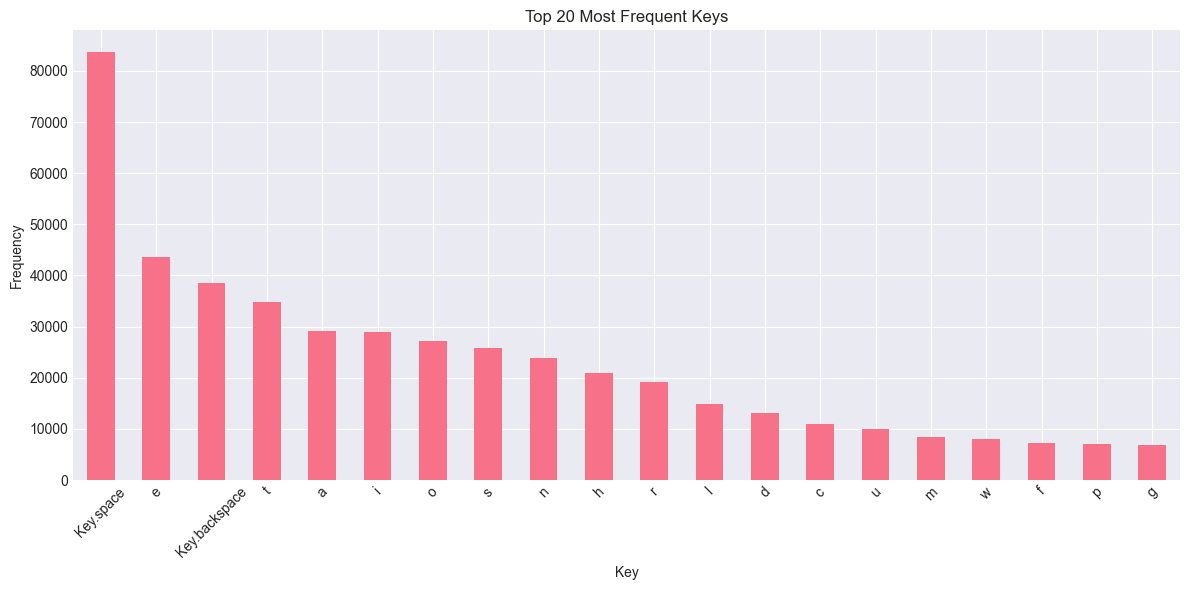

In [59]:
# Most common keys
all_keys = pd.concat([valid_df['key1'], valid_df['key2']])
key_freq = all_keys.value_counts().head(20)

plt.figure(figsize=(12, 6))
key_freq.plot(kind='bar')
plt.title('Top 20 Most Frequent Keys')
plt.xlabel('Key')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Key transition analysis


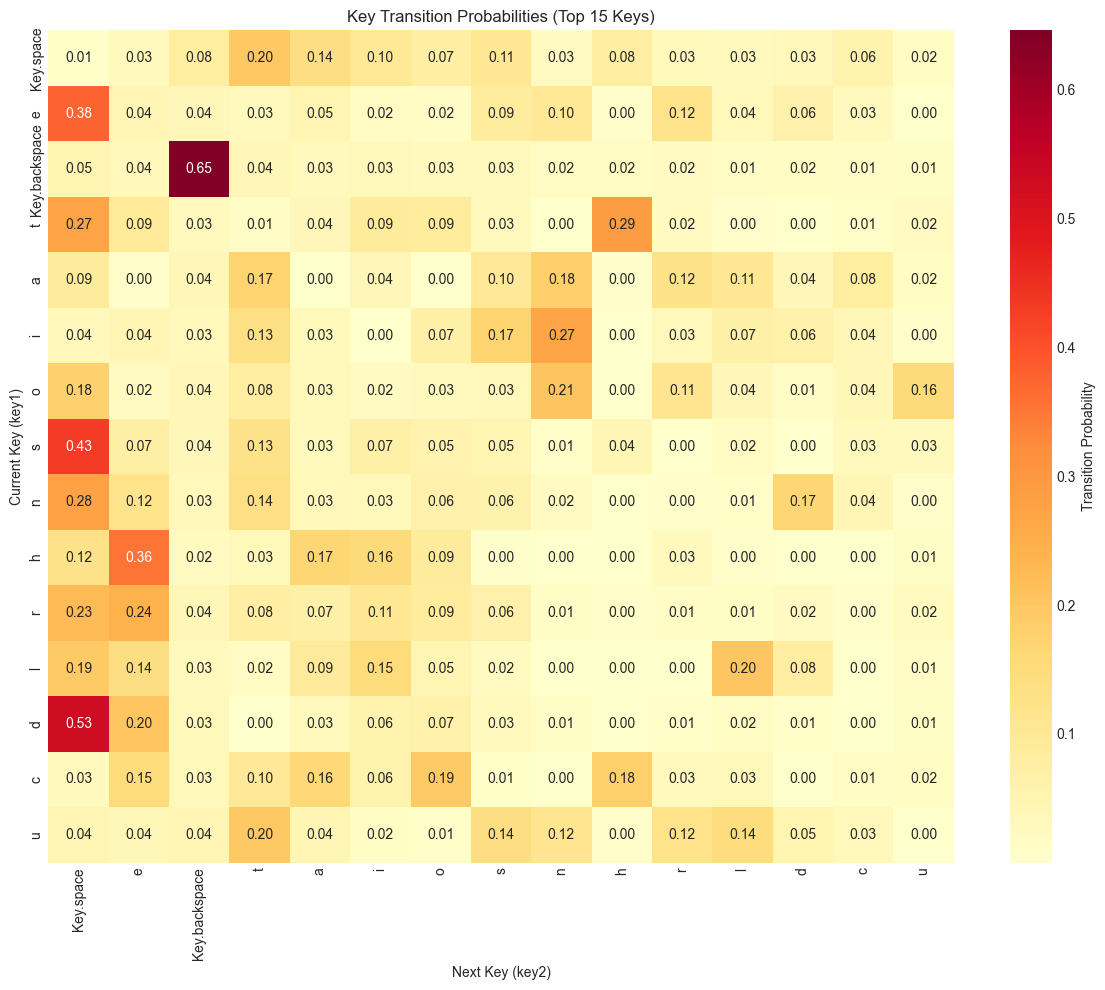

In [60]:
from collections import defaultdict

# Create transition matrix
transitions = defaultdict(lambda: defaultdict(int))
for _, row in valid_df.iterrows():
    transitions[row['key1']][row['key2']] += 1

# Convert to DataFrame for top keys
top_keys = key_freq.head(15).index
transition_matrix = pd.DataFrame(index=top_keys, columns=top_keys, data=0)

for key1 in top_keys:
    for key2 in top_keys:
        transition_matrix.loc[key1, key2] = transitions[key1][key2]

# Normalize by row
transition_prob = transition_matrix.div(transition_matrix.sum(axis=1), axis=0).fillna(0)

# Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(transition_prob, cmap='YlOrRd', annot=True, fmt='.2f', cbar_kws={'label': 'Transition Probability'})
plt.title('Key Transition Probabilities (Top 15 Keys)')
plt.xlabel('Next Key (key2)')
plt.ylabel('Current Key (key1)')
plt.tight_layout()
plt.show()

## 6. Advanced Analysis: Typing Rhythm and Consistency


In [61]:
# Calculate typing rhythm consistency for each user
user_consistency = valid_df.groupby('user_id').agg({
    'IL_ms': lambda x: x.std() / x.mean() if x.mean() > 0 else np.nan,  # Coefficient of variation
    'HL_ms': lambda x: x.std() / x.mean() if x.mean() > 0 else np.nan,
}).rename(columns={'IL_ms': 'IL_cv', 'HL_ms': 'HL_cv'})

# Users with most consistent typing (lowest CV)
most_consistent = user_consistency.nsmallest(10, 'IL_cv')
print("Users with most consistent typing rhythm (based on Inter-key Latency):")
display(most_consistent.round(3))

Users with most consistent typing rhythm (based on Inter-key Latency):


,IL_cv,HL_cv
user_id,,
1063,3.870,0.818
1039,4.143,1.278
1052,4.228,0.294
1041,4.300,0.583
1013,4.378,1.090
1050,4.475,0.580
1007,4.631,1.104
1036,5.226,1.198
1009,5.612,0.819


# Session-level analysis


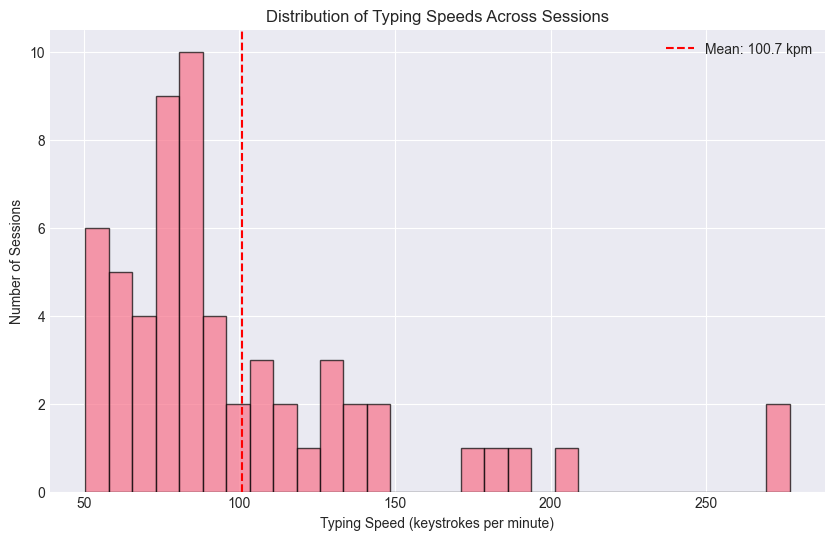

In [62]:
# Session-level analysis
session_stats = valid_df.groupby(['user_id', 'session_id']).agg({
    'key1': 'count',
    'IL_ms': 'mean',
    'HL_ms': 'mean'
}).rename(columns={'key1': 'keystroke_count'})

# Calculate typing speed (keystrokes per minute) - approximation
session_stats['approx_duration_ms'] = valid_df.groupby(['user_id', 'session_id'])['key1_timestamp'].agg(lambda x: x.max() - x.min()) / 1_000_000
session_stats['typing_speed_kpm'] = (session_stats['keystroke_count'] / session_stats['approx_duration_ms']) * 60000

# Filter out sessions with unrealistic speeds
session_stats = session_stats[session_stats['typing_speed_kpm'].between(50, 500)]

plt.figure(figsize=(10, 6))
session_stats['typing_speed_kpm'].hist(bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Typing Speed (keystrokes per minute)')
plt.ylabel('Number of Sessions')
plt.title('Distribution of Typing Speeds Across Sessions')
plt.axvline(session_stats['typing_speed_kpm'].mean(), color='red', linestyle='--', 
            label=f'Mean: {session_stats["typing_speed_kpm"].mean():.1f} kpm')
plt.legend()
plt.show()

## 7. Custom Analysis Functions


=== Typing Profile for User 1056 ===
Total keystrokes: 3321
Valid keystrokes: 2846 (85.7%)
Sessions: 2
Platforms used: [2 1 3]

Timing Statistics (ms):
  HL: mean=72.9, std=35.1, median=71.0
  IL: mean=788.9, std=4767.3, median=250.0
  PL: mean=861.8, std=4766.2, median=328.5
  RL: mean=862.2, std=4768.2, median=321.0

Top 10 most used keys:
Key.space        936
t                448
e                364
h                334
a                324
s                314
o                308
i                304
Key.backspace    298
n                186


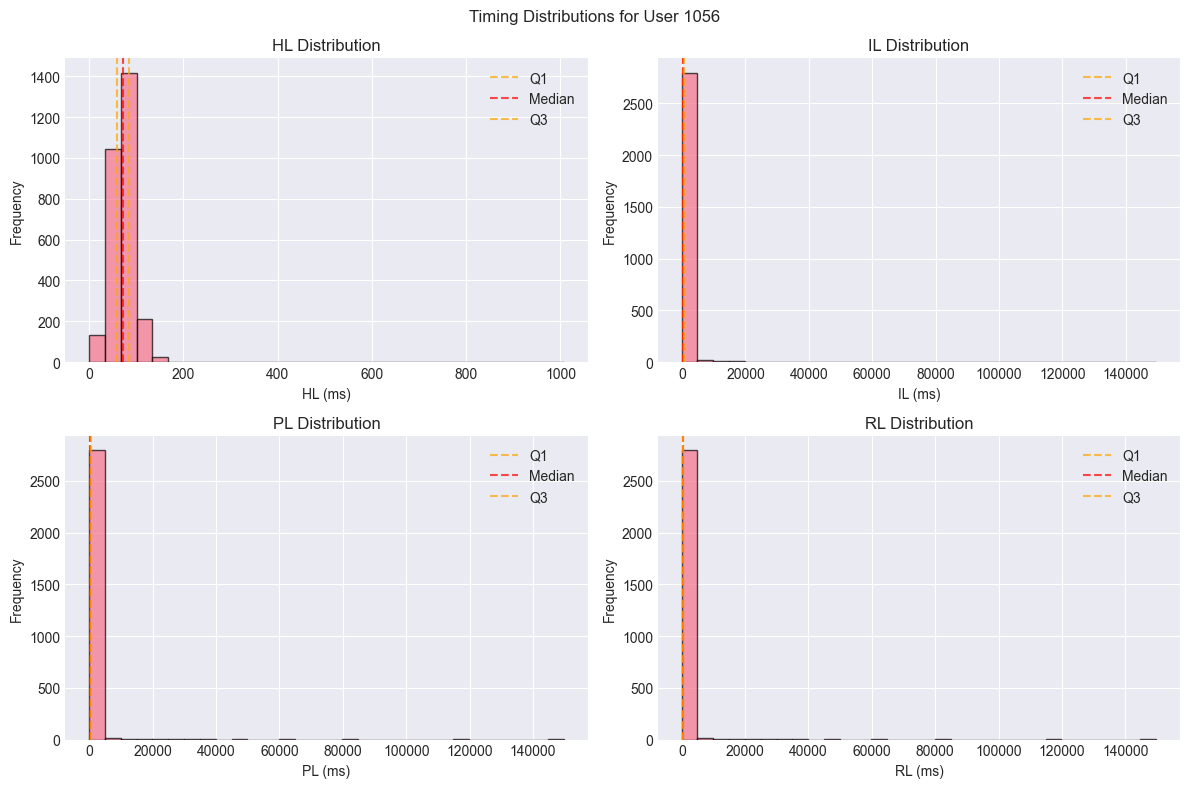

In [63]:
def analyze_user_typing_profile(user_id, df=df):
    """Generate a detailed typing profile for a specific user"""
    
    user_data = df[df['user_id'] == user_id]
    valid_data = user_data[user_data['valid']]
    
    if len(user_data) == 0:
        print(f"No data found for user {user_id}")
        return
    
    print(f"=== Typing Profile for User {user_id} ===")
    print(f"Total keystrokes: {len(user_data)}")
    print(f"Valid keystrokes: {len(valid_data)} ({len(valid_data)/len(user_data)*100:.1f}%)")
    print(f"Sessions: {user_data['session_id'].nunique()}")
    print(f"Platforms used: {user_data['platform_id'].unique()}")
    
    if len(valid_data) > 0:
        print(f"\nTiming Statistics (ms):")
        for feature in timing_features:
            feature_ms = f'{feature}_ms'
            print(f"  {feature}: mean={valid_data[feature_ms].mean():.1f}, "
                  f"std={valid_data[feature_ms].std():.1f}, "
                  f"median={valid_data[feature_ms].median():.1f}")
        
        # Most common keys
        user_keys = pd.concat([valid_data['key1'], valid_data['key2']])
        print(f"\nTop 10 most used keys:")
        print(user_keys.value_counts().head(10).to_string())
        
        # Visualize timing patterns
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        axes = axes.ravel()
        
        for i, feature in enumerate(timing_features):
            feature_ms = f'{feature}_ms'
            axes[i].hist(valid_data[feature_ms], bins=30, alpha=0.7, edgecolor='black')
            axes[i].set_xlabel(f'{feature} (ms)')
            axes[i].set_ylabel('Frequency')
            axes[i].set_title(f'{feature} Distribution')
            
            # Add percentile lines
            p25, p50, p75 = valid_data[feature_ms].quantile([0.25, 0.5, 0.75])
            axes[i].axvline(p25, color='orange', linestyle='--', alpha=0.7, label='Q1')
            axes[i].axvline(p50, color='red', linestyle='--', alpha=0.7, label='Median')
            axes[i].axvline(p75, color='orange', linestyle='--', alpha=0.7, label='Q3')
            axes[i].legend()
        
        plt.suptitle(f'Timing Distributions for User {user_id}')
        plt.tight_layout()
        plt.show()

# Example usage
analyze_user_typing_profile(df['user_id'].iloc[0])

In [64]:
def compare_users(user_ids, df=df):
    """Compare typing patterns between multiple users"""
    
    comparison_data = []
    
    for user_id in user_ids:
        user_data = df[(df['user_id'] == user_id) & df['valid']]
        
        if len(user_data) > 0:
            stats = {
                'user_id': user_id,
                'keystroke_count': len(user_data),
                'mean_HL': user_data['HL_ms'].mean(),
                'mean_IL': user_data['IL_ms'].mean(),
                'mean_PL': user_data['PL_ms'].mean(),
                'mean_RL': user_data['RL_ms'].mean(),
                'typing_consistency': user_data['IL_ms'].std() / user_data['IL_ms'].mean()
            }
            comparison_data.append(stats)
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Radar chart
    categories = ['mean_HL', 'mean_IL', 'mean_PL', 'mean_RL']
    
    fig = go.Figure()
    
    for _, user in comparison_df.iterrows():
        fig.add_trace(go.Scatterpolar(
            r=[user[cat] for cat in categories],
            theta=categories,
            fill='toself',
            name=f'User {user["user_id"]}'
        ))
    
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, comparison_df[categories].max().max()]
            )),
        showlegend=True,
        title="User Typing Pattern Comparison"
    )
    
    fig.show()
    
    return comparison_df

# Example: Compare first 5 users
sample_users = df['user_id'].unique()[:5]
comparison = compare_users(sample_users)
display(comparison)

,user_id,keystroke_count,mean_HL,mean_IL,mean_PL,mean_RL,typing_consistency
0,1056,2846,72.878219,788.889935,861.768154,862.222340,6.043090
1,1051,2860,112.318957,786.893611,899.212568,898.389403,20.284035
2,1058,8696,107.965802,395.150074,503.115876,503.267821,6.647250
3,1005,6984,106.735516,126.888119,233.623635,235.174521,7.520233
4,1002,5166,96.193858,143.881236,240.075094,240.183249,9.336452


## 8. Export Functions for Team Collaboration


In [65]:
def export_user_subset(user_ids, output_file='user_subset.csv'):
    """Export data for specific users"""
    subset = df[df['user_id'].isin(user_ids)]
    subset.to_csv(output_file, index=False)
    print(f"Exported {len(subset)} records for {len(user_ids)} users to {output_file}")

def export_session_summary(output_file='session_summary.csv'):
    """Export session-level summary statistics"""
    session_summary = df.groupby(['user_id', 'platform_id', 'video_id', 'session_id']).agg({
        'key1': 'count',
        'valid': ['sum', 'mean'],
        'HL': 'mean',
        'IL': 'mean',
        'PL': 'mean',
        'RL': 'mean'
    })
    
    session_summary.columns = ['_'.join(col).strip() for col in session_summary.columns]
    session_summary.to_csv(output_file)
    print(f"Session summary exported to {output_file}")

# Run exports
export_session_summary(output_file=os.path.join(save_summary_session_directory, 'session_summary.csv'))



Session summary exported to processed_data-2025-05-24_144726-Loris-MBP.cable.rcn.com/session_summary.csv
